# get_pond_properties
Author: Connor Finn <br>
Date: July 29, 2020 <br>
Description: <dir>
    This notebook will be used to determine the geometric properties of the salton sea. To accomplish this, I read in a number of pictures from my desired location, use the watermask method demonstrated by Arvind, and used the area quantification method used by Prabhakar to calculate sqare kilometers. 

In [184]:
import ee
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

# Trigger the authentication flow.
ee.Authenticate()

Enter verification code: 4/2gHlTmVPigD26QBxOZS0_OVC9KbHyqvLTiIUtmvm9QOLGzqrNh3pvQY

Successfully saved authorization token.


In [185]:
ee.Initialize()

# Collect an image

## Part 1: Collect the images - all during the month of May (same as time lapse)

In [207]:
def get_images(path_list , row_list , satelite , start_date , end_date , max_cloud_percentage , months):
    
    # get image collection object
    coll = ee.ImageCollection(satelite)\
        .filterDate(start_date, end_date)\
        .filter(ee.Filter.inList('WRS_PATH', path_list))\
        .filter(ee.Filter.inList('WRS_ROW', row_list))\
        .filter(ee.Filter.lt('CLOUD_COVER' , max_cloud_percentage))\
        .filter(ee.Filter.calendarRange(months[0],months[1],'month'))    # just may data
    # get image_id's
    image_ids = list( map( lambda x : x['id'] , coll.getInfo()['features'] ) ) 
    
    # get image objects
    images = list( map( lambda x: ee.Image(x) , image_ids ) )
    
    return images


In [208]:
# fill in the information
p = [39]                                    # path       
r = [37]                                    # row 
sat = 'LANDSAT/LC08/C01/T1_TOA'             # use this satelite
sd = '2013-05-01'                           # start date
ed = '2020-05-01'                           # end date
cc= 1                                       # max cloud cover percentage
months = [5 , 5]                            # months [start, end]
image_list = get_images(p, r, sat, sd, ed, cc , months)

## Reduce the images to just the lake

In [209]:
lake_bounding_box = ([-116.21,33.58],\
 [-116.19,33.03],\
 [-115.36,33.04],\
 [-115.40,33.65])

lake_region = ee.Geometry.Rectangle([-116.21 , 33.03 , -115.36 , 33.65])

In [210]:
# This function adds a band with the ndvi.

def addNDWI(image):
    return image.addBands(image.normalizedDifference(['B5', 'B7']))


def addNDVI(image):
    return image.addBands(image.normalizedDifference(['B3', 'B5']))

In [211]:
# this function clip to the lake
def clip(image):
    lake_region = ee.Geometry.Rectangle([-116.21 , 33.03 , -115.36 , 33.65])
    return image.clip(lake_region)

## Add NDWI, and display

In [212]:
image_list = list(map(addNDWI, image_list))        # set as 'nd'
image_list = list(map(clip, image_list))


parameters = {'min': -1.0, # value which is mapped to 0
              'max': 1.0,  # value which is mapped to 255
              'dimensions': 768,   # size of the image 
              'bands': ['nd'],     # The bands we select
              'palette': ['green', 'white', 'blue'],  # only use a pallete when visualizing one.
              #'region': lake_region
}

lake_image = image_list[0]
display(Image(url = lake_image.getThumbUrl(parameters)))

## Add NDVI, and display

In [213]:
image_list = list(map(addNDVI, image_list))        # set as 'nd_1'
parameters = {'min': -1.0, # value which is mapped to 0
              'max': 1.0,  # value which is mapped to 255
              'dimensions': 768,   # size of the image 
              'bands': ['nd_1'],     # The bands we select
              'palette': ['green', 'white', 'blue'],  # only use a pallete when visualizing one.
              #'region': lake_region
}

lake_image = image_list[0]
display(Image(url = lake_image.getThumbUrl(parameters)))

# Create a Water mask here
To follow with this [tutorial](https://developers.google.com/earth-engine/tutorial_forest_03), we need a band which gives a value equal to 1 for (in the lake), and 0 elsewise. <br>
I can see this expanding to a 1 for any location where land turns to water in future situations <dir>
    
    For now. This will be done using a water mask on the ndwi value. We will say use 0.01 as the cutoff value. Arvind provided the base code for creating the following watermask. I will then use the tutorial as well as some code provided to me by Prabhakar to calculate a numerical value for the water. 

## Part 1. May 2013

In [214]:
#Creating a water mask  based on the histogram shown earlier.
waterthreshold = .1;
image_ndvi = lake_image.select(['nd_1'])

watermask = image_ndvi.gte(waterthreshold) #creating a water mask. Any NDWI greater than waterthreshold value is taken to be water.

parameters = {'min': -0.5,
              'max': 0.4,
              'dimensions': 768,
              'palette': ['brown', 'white', 'blue'],
}
Image(url = watermask.getThumbUrl(parameters))

(array([810.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 169.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

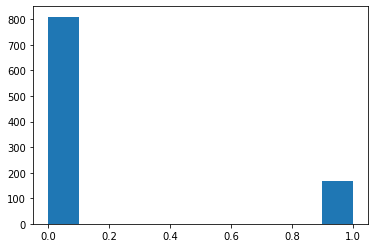

In [215]:
#What is in the watermask?
watermask_data = ee.List(watermask.sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['nd_1']).get('list')).getInfo()
plt.hist(watermask_data) # You can see that the mask is a contrast - greater than threshold is categorized as 1 and the rest as 0.

### Compute area

To help compute areas, Earth Engine has the ee.Image.pixelArea() method which generates an image in which the value of each pixel is the pixel's area in square meters. Note that I am converting the javascript example to python here. The dictionary is now simply keywords.

In [216]:
'''
I calculate the sum of the water in the region.
Note that the pixel value is 1 where there is water and 0 where there is land. 
For this reason, a simple summation call will collect all the water pixels in the area. 
''' 
pixel_stats = watermask.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        )

In [217]:
print( "The amount of pixels representing water in this image are, " , pixel_stats.getInfo()['nd_1'] )

The amount of pixels representing water in this image are,  1013983


### To convert to square meters. i use the ee.Image.pixelArea() method
This is a method Prabhakar used, and is also used in the tutorial

In [218]:
watermask_square_meter = watermask.multiply(ee.Image.pixelArea()).divide(1000*1000)

In [219]:
sqm_stats = watermask_square_meter.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        )

In [220]:
print( "The amount of square kilometers representing water in this image are, " , sqm_stats.getInfo()['nd_1'] )

The amount of square kilometers representing water in this image are,  913.0398384740643


## Part 2. May 2020
I recognize that this is a noisy estimate. However, I will use the last image and see if there has been any reduction.

In [221]:
last_lake_image = image_list[-1]

In [222]:
last_image_ndvi = last_lake_image.select(['nd_1'])
last_watermask = last_image_ndvi.gte(waterthreshold) #creating a water mask. Any NDWI greater than waterthreshold value is taken to be water.

parameters = {'min': -0.5,
              'max': 0.4,
              'dimensions': 768,
              'palette': ['brown', 'white', 'blue'],
}
Image(url = last_watermask.getThumbUrl(parameters))

In [223]:
last_watermask_square_meter = last_watermask.multiply(ee.Image.pixelArea()).divide(1000*1000)

last_pixel_stats = last_watermask.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        )


last_sqm_stats = last_watermask_square_meter.reduceRegion(\
        reducer = ee.Reducer.sum(),\
        scale =  30\
        )
print( "The amount of pixels representing water in this image are, " , last_pixel_stats.getInfo()['nd_1'] )
print( "The amount of square kilometers representing water in this image are, " , last_sqm_stats.getInfo()['nd_1'] )

The amount of pixels representing water in this image are,  969300
The amount of square kilometers representing water in this image are,  872.8058068843353
